# Kaggle competition: Spaceship Titanic classification problem

Andre Moreira, 2023


## Background

This Notebook is prepared in the simplest possible way as a first shot into the competition. Part of the code recycled from the "classical Titanic" competition

In this version I do more work on the validation part

## Preamble


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

from sklearn import preprocessing

# We do not use most of it, here just in case...

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import ensemble

from sklearn import linear_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

import sklearn.metrics as metrics

from xgboost import XGBRegressor
from xgboost import XGBClassifier

In [2]:
# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_rows', None)

In [3]:
# Improve plot resolutions (matplotlib, sns)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})

This function is to plot the confusion matrix.


In [4]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, cmap ='Greens', annot=True, fmt=".0f", linewidths = 0.5, 
                linecolor='black',ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']) 
    plt.show() 

In [5]:
# function to get the value of the confusion matrix
def cm_res(Y_t, Y_hat):
    cm_a = confusion_matrix(Y_t, Y_hat)
    tp = cm_a[1][1]
    tn = cm_a[0][0]
    fp = cm_a[0][1]
    fn = cm_a[1][0]
    return tp, tn, fp, fn

In [6]:
# this prepares for the overview, shows the confusion matrix
def overw(X, Y, Y_hat, fitter):
    plot_confusion_matrix(Y,Y_hat)
    a = fitter.score(X, Y)
    b = metrics.f1_score(Y, Y_hat)
    c = metrics.roc_auc_score(Y, Y_hat)
    return a, b, c

## Load and clean the data


### Upload and clean it

In [7]:
# This is the training data
#data = pd.read_csv("train.csv") # for local data

# This is the test / prediction data
#data_pred = pd.read_csv("test.csv")

#
# If running in Kaggle, comment the lines above and use this:
#

# This is the training data
data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")


# This is the test / prediction data
data_pred = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [8]:
data.shape

(8693, 14)

In [9]:
data_pred.shape

(4277, 13)

In [10]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
# First, copy the data into dataframes that we will use throughout the notebook. In case later we want to "reset", no need to upload the data again.
df = data.copy()
df_pred = data_pred.copy()

#### Encode categorical data

In [12]:
# Store the passager ID as index

df.set_index("PassengerId", inplace = True)
df_pred.set_index("PassengerId", inplace = True)

In [13]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [14]:
# Extract the target set
Y = df["Transported"].to_numpy(copy = True, dtype = float)
Y

array([0., 1., 0., ..., 1., 0., 1.])

In [15]:
# Convert categorical to one-hot encoding - but first let's check how practical that is
print(len(df["HomePlanet"].unique()))
print(len(df["Cabin"].unique()))
print(len(df["Destination"].unique()))
print(len(df_pred["HomePlanet"].unique()))
print(len(df_pred["Cabin"].unique()))
print(len(df_pred["Destination"].unique()))

4
6561
4
4
3266
4


For the category "Cabin" there too many unique values - we will not one-hot encode them, we will for now drop them.

As for the others: it looks good, not too many unique values per category - so we can proceed with one-hot enconding.

In [16]:
# focus on the columns that we will one-hot encode
df_X = df.drop(columns = ["Cabin"]).loc[:,"HomePlanet":"VRDeck"].copy()
df_X_pred = df_pred.drop(columns = ["Cabin"]).loc[:,"HomePlanet":"VRDeck"].copy()

In [17]:
df_X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
PassengerId,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0


In [18]:
# Before one-hot encoding categorical data, convert "True / False" into "1 / 0".

df_X[["CryoSleep", "VIP"]] = df_X[["CryoSleep", "VIP"]].astype(float)
df_X_pred[["CryoSleep", "VIP"]] = df_X_pred[["CryoSleep", "VIP"]].astype(float)

In [19]:
df_X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
PassengerId,,,,,,,,,,
0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0
0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0
0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0
0003_02,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0
0004_01,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0


In [20]:
# These are the encoded variables that we will later use for modeling

df_X_num = pd.get_dummies(df_X, dtype=float)
df_X_pred_num = pd.get_dummies(df_X_pred, dtype=float)

In [21]:
df_X_num.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
PassengerId,,,,,,,,,,,,,,
0001_01,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
0002_01,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,0.0,0.0,0.0,0.0,1.0
0003_01,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,1.0,0.0,0.0,0.0,1.0
0003_02,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,1.0,0.0,0.0,0.0,1.0
0004_01,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0


In [22]:
df_X_num.shape

(8693, 14)

#### Sandbox: change the columns structure

NB: after encoding and before cleaning up further, we can change which columns we keep or let go.

**Comment / Uncomment for effect**

In [23]:
# Keep a copy if later we want to come back and use the full list

df_X_num_copy = df_X_num.copy()
df_X_pred_num_copy = df_X_pred_num.copy()

In [24]:
# Just for fun: try reducing the variables to the ones with ABS(correlation) with Y that is higher 
# than a threshold, e.g. 0.2
# (uncomment for effect)

# short_list = ["CryoSleep_True", "CryoSleep_False", "RoomService", "Spa", "VRDeck"]

#df_X_num = df_X_num[short_list]
#df_X_pred_num = df_X_pred_num[short_list]

In [25]:
# Just for fun: try reducing the variables to the ones with ABS(correlation) with Y that is higher 
# than a threshold, e.g. 0.2
# Combine with the comment found at Kaggle, see if this works.
# (uncomment for effect)

# short_list = ["CryoSleep_True", "CryoSleep_False", "RoomService", "Spa", "VRDeck"]

#df_X_num = df_X_num[short_list]
#df_X_pred_num = df_X_pred_num[short_list]

In [26]:
# df_X_num["Ammenities"] = df_X_num["RoomService"] + df_X_num["FoodCourt"] + df_X_num["ShoppingMall"] + df_X_num["Spa"] + df_X_num["VRDeck"]
# df_X_pred_num["Ammenities"] = df_X_pred_num["RoomService"] + df_X_pred_num["FoodCourt"] + df_X_pred_num["ShoppingMall"] + df_X_pred_num["Spa"] + df_X_pred_num["VRDeck"]

#### Clean up the NaNs

In [27]:
# Are there many NaNs in the encoded variables?

print(df_X_num.isna().sum(), "\n \n")
print(df_X_pred_num.isna().sum(), "\n \n")
print("fraction of NaN in df_X_num = ", df_X_num.isna().sum().max()/len(df_X_num), 
      "  fraction of NaN in df_X_pred_num = ", df_X_pred_num.isna().sum().max()/len(df_X_pred_num))

CryoSleep                    217
Age                          179
VIP                          203
RoomService                  181
FoodCourt                    183
ShoppingMall                 208
Spa                          183
VRDeck                       188
HomePlanet_Earth               0
HomePlanet_Europa              0
HomePlanet_Mars                0
Destination_55 Cancri e        0
Destination_PSO J318.5-22      0
Destination_TRAPPIST-1e        0
dtype: int64 
 

CryoSleep                     93
Age                           91
VIP                           93
RoomService                   82
FoodCourt                    106
ShoppingMall                  98
Spa                          101
VRDeck                        80
HomePlanet_Earth               0
HomePlanet_Europa              0
HomePlanet_Mars                0
Destination_55 Cancri e        0
Destination_PSO J318.5-22      0
Destination_TRAPPIST-1e        0
dtype: int64 
 

fraction of NaN in df_X_num =  0.024962613

In [28]:
# In a first (and simplified approach), we substitute the NaN values for the average values in each column.
# This may be enough because each column has a much larger number of variables than the highest number of NaN 

for i in df_X_num.columns[df_X_num.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    df_X_num[i].fillna(df_X_num[i].mean(),inplace=True)

for i in df_X_pred_num.columns[df_X_pred_num.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    df_X_pred_num[i].fillna(df_X_pred_num[i].mean(),inplace=True)

In [29]:
# Double check
print("fraction of NaN in df_X_num = ", df_X_num.isna().sum().max()/len(df_X_num), 
      "  fraction of NaN in df_X_pred_num = ", df_X_pred_num.isna().sum().max()/len(df_X_pred_num))

fraction of NaN in df_X_num =  0.0   fraction of NaN in df_X_pred_num =  0.0


In [30]:
df_X_num.shape[0]

8693

In [31]:
len(Y)

8693

Importantly, X and Y have the same number of rows ("same shape" in this context).

#### Correlations

In [32]:
# How are the correlations among the variables and target?

df_aux = df_X_num.copy() # create an auxiliary DF for the analysis; must be a copy, otherwise df_X_num is modified
df_aux[["Y"]] = df[["Transported"]].astype(float) # for the correlation analysis, add the target column to this auxiliary DF  
aux = df_aux.corr(numeric_only = True, method = "pearson") # correlation matrix

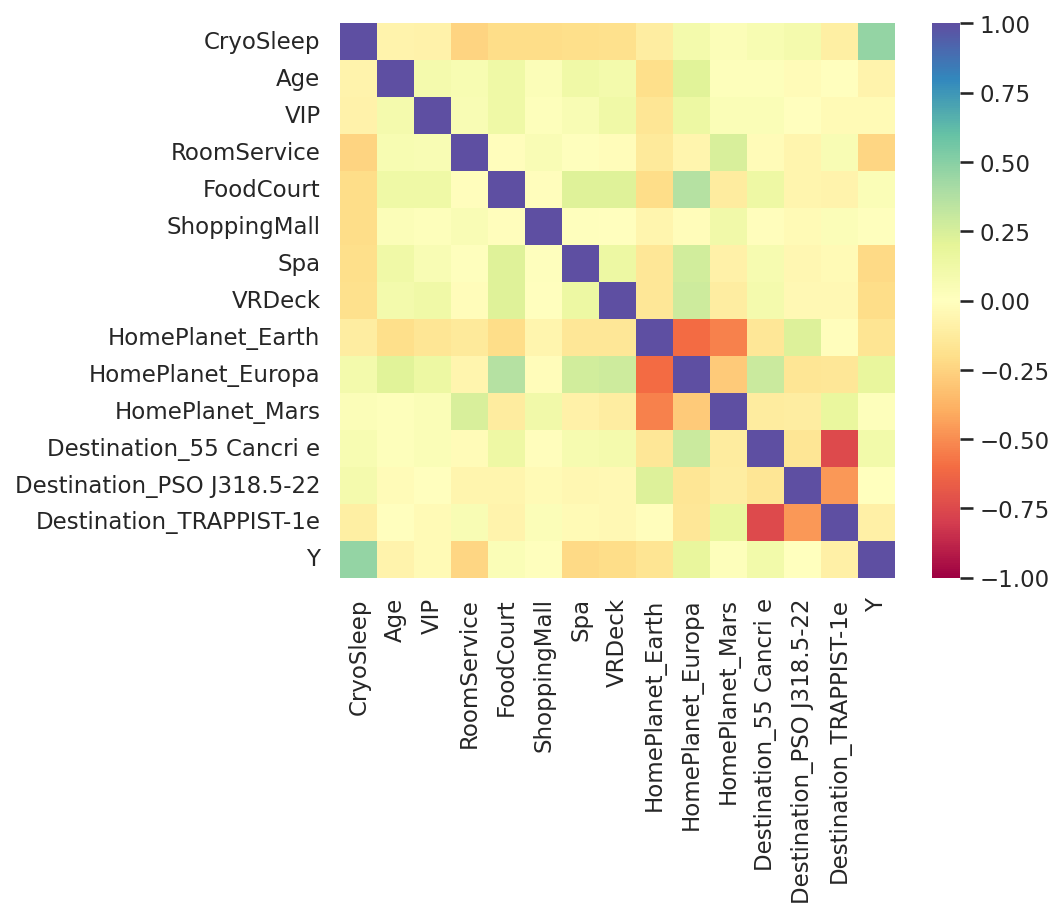

In [33]:
# Plot the matrix as a whole

sns.heatmap(aux, cmap="Spectral", annot=False, square = True,
            vmin=-1, vmax=+1, center = 0)
plt.show()

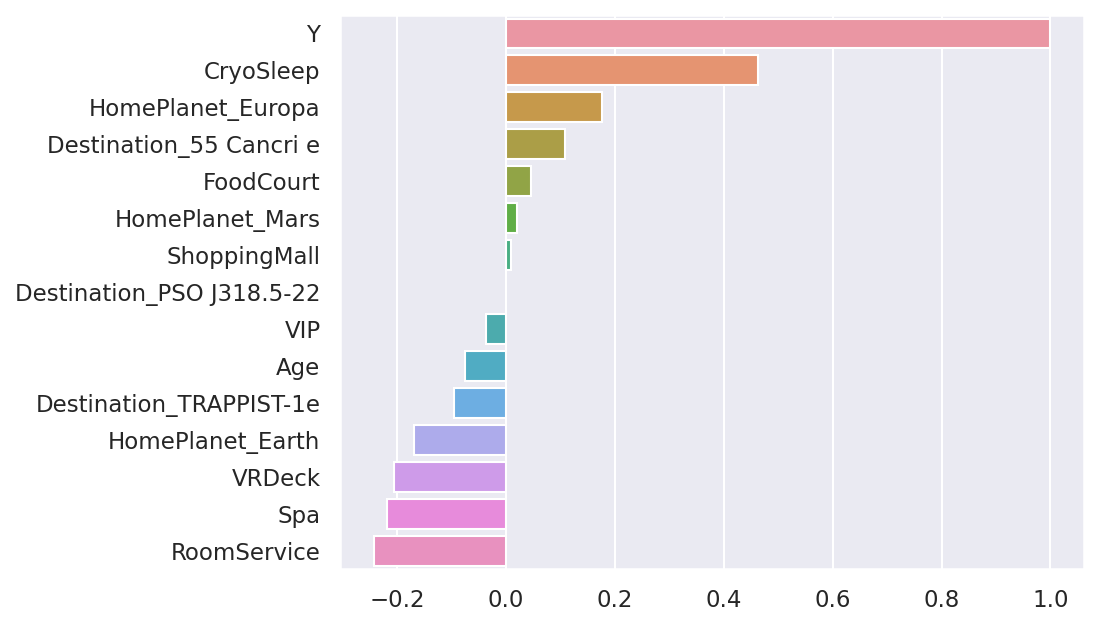

In [34]:
# Look at the correlation between Y and the different variables 

sns.barplot(aux[["Y"]].sort_values(by = "Y", ascending = False).T, orient="h")
plt.show()

The strongest correlation between Y ("Transported") shows with being in cryoSleep or not.

## Set up cross-validation data

In [35]:
# In this dataset, what is the probability of transportation? 
Y.mean()

0.5036236051995858

In [36]:
# Prepare the variable set, which we will call X
# Center and scale X so we can feed it into the models without worrying about unit variance.

X = preprocessing.StandardScaler().fit(df_X_num).transform(df_X_num)
X[0:2]

array([[-0.75674966,  0.70943692, -0.15676679, -0.34058987, -0.28731404,
        -0.29081703, -0.27666342, -0.26902263, -1.06061696,  1.754795  ,
        -0.50366411, -0.51101319, -0.31748665,  0.68531265],
       [-0.75674966, -0.33671733, -0.15676679, -0.1753636 , -0.28166908,
        -0.24896783,  0.2115053 , -0.23019432,  0.94284745, -0.56986714,
        -0.50366411, -0.51101319, -0.31748665,  0.68531265]])

We split the data into training and testing data using the  function  <code>train_test_split</code>. Note that according to the documentation, train_test_split defaults into a shuffled and stratified split, which is the best option for this type of problems when dealing with skewed variables.

The training data and test data is assigned to the following labels:

<code>X_train, X_test, Y_train, Y_test</code>

*Look for a split between train and test that reflects the 0/1 distribution of the total set*


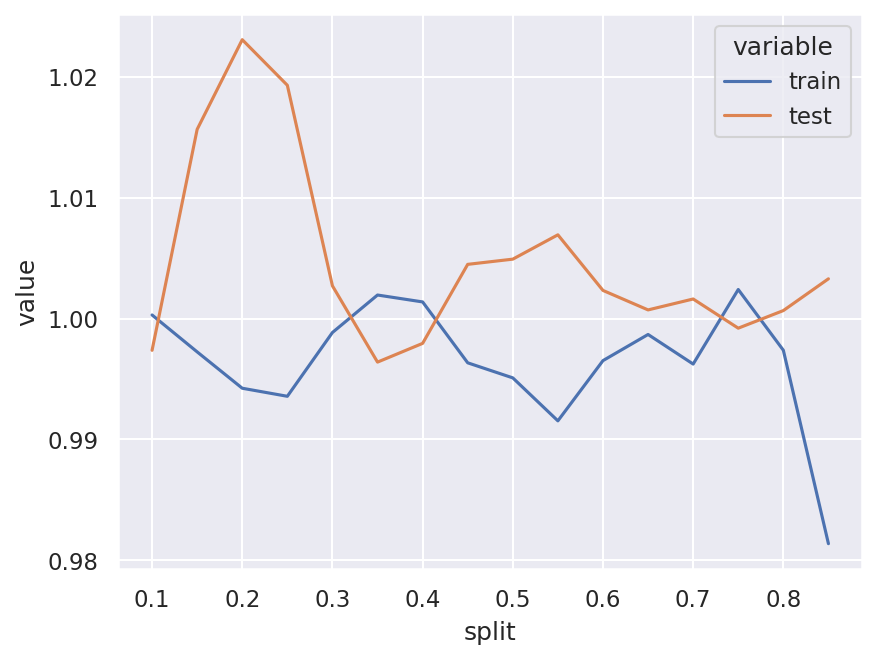

In [37]:
# Run the split parameter across values to see how the average Y behaves

aux = []
yy = Y.mean()
rand_st = 1

for i in np.arange(0.1, 0.9, 0.05):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=i, random_state=rand_st)
    aux = aux + [[i, Y_train.mean()/yy, Y_test.mean()/yy]]
df_aux = pd.DataFrame(aux, columns=["split","train","test"])
sns.lineplot(x='split', y='value', hue='variable', data=pd.melt(df_aux, ['split']))
plt.show()

**The conclusion from the graph above**

By using a deterministic random state, we can look for a split value that brings the average Y in the train and test sets as close to average y across the complete dataset. In this way, the risk that we train the data on an artificially skewed set is minimized.

In [38]:
# Here we split train/test, use as global variables when calling functions

# Note that according to the documentation, train_test_split defaults into a shuffled and stratified split
# which is the best option for this type of problems when dealing with skewed variables.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.32, random_state=rand_st)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)
print(Y.mean())
print(Y_train.mean())
print(Y_test.mean())

Train set: (5911, 14) (5911,)
Test set: (2782, 14) (2782,)
0.5036236051995858
0.5044831669768228
0.5017972681524083


## Modelling

In [39]:
# Define a function that we will use to fit the models to the data

def fitting(model, params):
    model_cv = GridSearchCV(model, params, cv = 10, verbose = 1)
    model_cv.fit(X_train, Y_train)
    print("Tuned hyperparameters :(best parameters) ",model_cv.best_params_)
    print("Best score :",model_cv.best_score_) # note that this is what is used to measure success in this Kaggle competition
    return(model_cv)

In [40]:
# Get a list ready to save scores

score_list = [["Model", "Score", "F1", "AUC"]]

### Logistic Regression

In [41]:
lr = LogisticRegression()
parameters ={"C":[0.05,1.0,1.5],'penalty':["l2"], 'solver':['lbfgs']} # l1 lasso l2 ridge

logreg_cv = fitting(lr, parameters)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Tuned hyperparameters :(best parameters)  {'C': 0.05, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score : 0.7792244020670417


Calculate the accuracy on the test data using the method <code>score</code>:


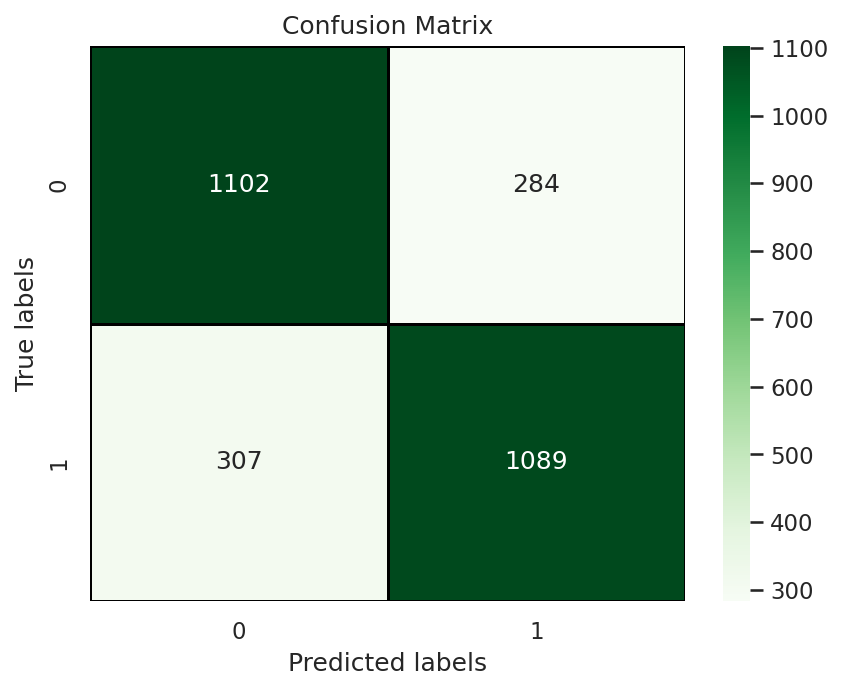

score =  0.7875629043853343   F1 =  0.7865655471289275 AUC =  0.787589877489591


In [42]:
# Store the score
scr, F1, auc = overw(X_test, Y_test, logreg_cv.predict(X_test), logreg_cv)
score_list = score_list + [["LR", scr, F1, auc]]
print("score = ", scr, "  F1 = ", F1, "AUC = ", auc)

### Random Forest

In [43]:
rf = ensemble.RandomForestClassifier(n_jobs = -1)
parameters ={} # l1 lasso l2 ridge

rf_cv = fitting(rf, parameters)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Tuned hyperparameters :(best parameters)  {}
Best score : 0.7785492980289935


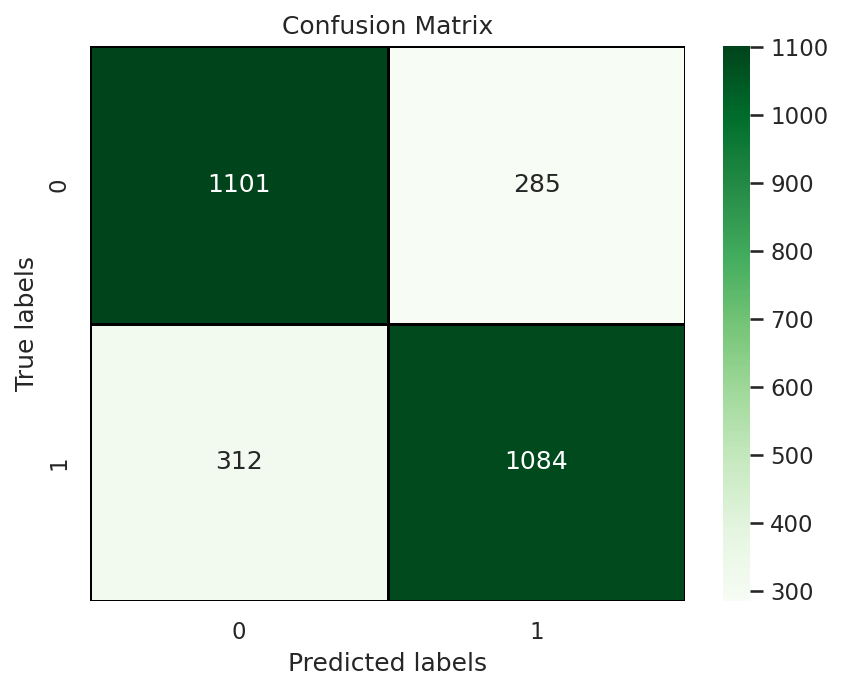

score =  0.7854061826024443   F1 =  0.7840867992766728 AUC =  0.7854382961832819


In [44]:
# Store the score
scr, F1, auc = overw(X_test, Y_test, rf_cv.predict(X_test), rf_cv)
score_list = score_list + [["RF", scr, F1, auc]]
print("score = ", scr, "  F1 = ", F1, "AUC = ", auc)

### XGBoost

In [45]:
xgb = XGBClassifier()
parameters ={"random_state":[0],"objective":["binary:logistic"], "n_estimators":[100], "booster":["dart"], "learning_rate":[0.05],
            "max_depth":[10]}

xgb_cv = fitting(xgb, parameters)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Tuned hyperparameters :(best parameters)  {'booster': 'dart', 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 0}
Best score : 0.7849787922440208


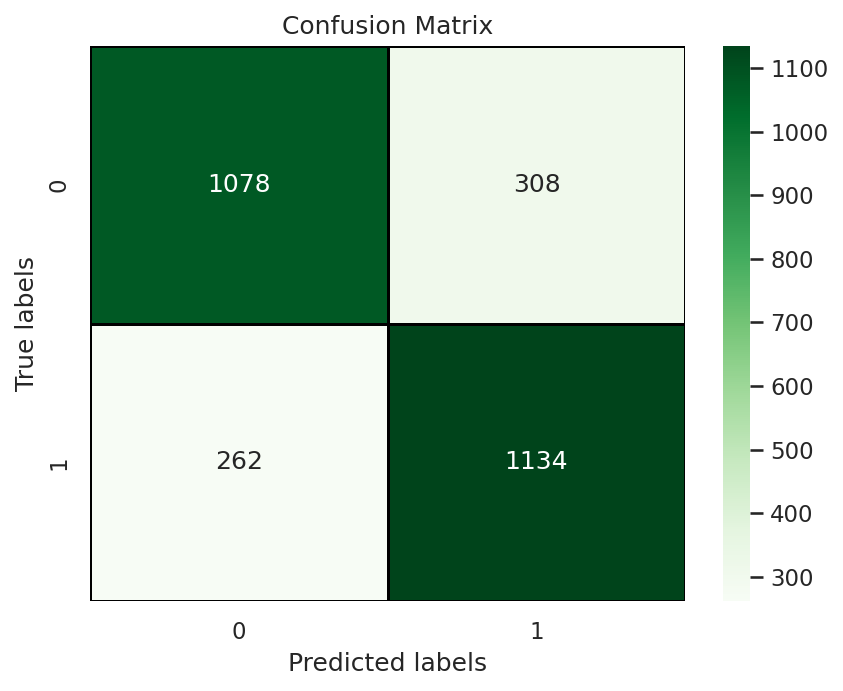

score =  0.7951114306254493   F1 =  0.7991543340380549 AUC =  0.795049347341611


In [46]:
# Store the score
scr, F1, auc = overw(X_test, Y_test, xgb_cv.predict(X_test), xgb_cv)
score_list = score_list + [["XGB", scr, F1, auc]]
print("score = ", scr, "  F1 = ", F1, "AUC = ", auc)

### Compare the models


In [47]:
Report = pd.DataFrame(score_list[1:], columns = score_list[0])
Report

,Model,Score,F1,AUC
0,LR,0.787563,0.786566,0.787590
1,RF,0.785406,0.784087,0.785438
2,XGB,0.795111,0.799154,0.795049


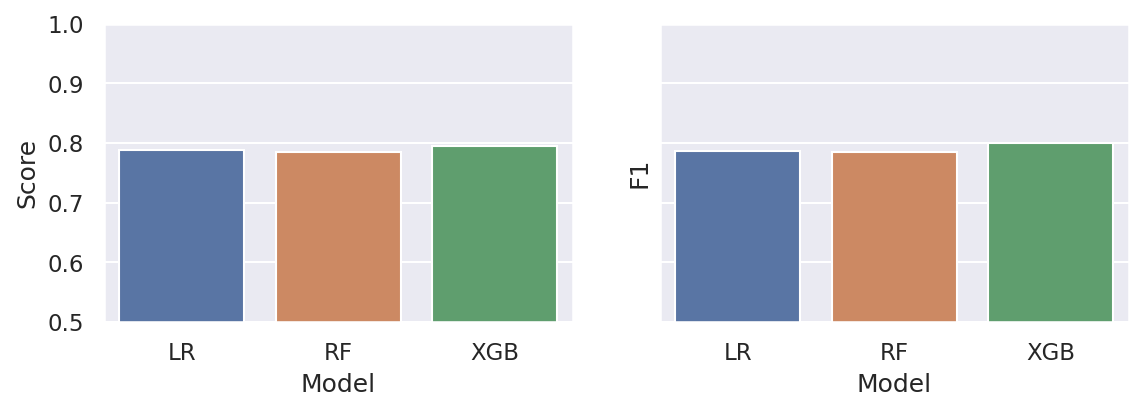

In [48]:
fig, axa = plt.subplots(ncols = 2, figsize = (8,3), sharey = True)
fig.tight_layout(pad=2.0)

sns.barplot(data=Report, x="Model", y="F1", ax = axa[1])

sns.barplot(data=Report, x="Model", y="Score", ax = axa[0])

axa[0].set_ylim(0.5, 1)

plt.show()

## Prediction

In [49]:
# Like we did before: center and scale it so we can feed it into the models without worrying about unit variance.
X_p = preprocessing.StandardScaler().fit(df_X_pred_num).transform(df_X_pred_num)
X_p[0:2]

array([[ 1.32206285, -0.11822162, -0.13566529, -0.36477954, -0.29135159,
        -0.31985918, -0.27455773, -0.25156055,  0.94338172, -0.55313127,
        -0.52531386, -0.49473362, -0.31586164,  0.66849659],
       [-0.77320646, -0.68860136, -0.13566529, -0.36477954, -0.28538513,
        -0.31985918,  2.28300781, -0.25156055,  0.94338172, -0.55313127,
        -0.52531386, -0.49473362, -0.31586164,  0.66849659]])

In [50]:
len(X_p)

4277

### Predictions from the models

In [51]:
# survey a model, get its prediction ready to save for upload
def pred(mod, data_p, X_p):
    Y_p = mod.predict(X_p)
    # prepare the DF with the predictions
    subm = pd.concat([pd.DataFrame(data_p, columns=["PassengerId"]), pd.DataFrame({'Transported': Y_p})], axis=1)
    print("Transported rates:")
    print("Total ensemble = ", Y.mean())
    print("Train = ", Y_train.mean())
    print("Test = ", Y_test.mean())
    print("Prediction = ", Y_p.mean())
    return(subm)

In [52]:
sub_LR = pred(logreg_cv, data_pred, X_p)

Transported rates:
Total ensemble =  0.5036236051995858
Train =  0.5044831669768228
Test =  0.5017972681524083
Prediction =  0.4956745382277297


In [53]:
sub_RF = pred(rf_cv, data_pred, X_p)

Transported rates:
Total ensemble =  0.5036236051995858
Train =  0.5044831669768228
Test =  0.5017972681524083
Prediction =  0.48117839607201307


In [54]:
sub_XGB = pred(xgb_cv, data_pred, X_p)

Transported rates:
Total ensemble =  0.5036236051995858
Train =  0.5044831669768228
Test =  0.5017972681524083
Prediction =  0.508534019172317


In [55]:
# choose a model to generate a submission

subm = sub_XGB  # model

# NB: chose XGB because overall showed a better performance, and the average predicted variable has
# the closest value to the original train/test set


subm.replace(to_replace = {1: True, 0: False}, inplace = True) # make sure 0 and 1 are now False and True
number = "XGB_2" # number of the this "trial", e.g. 20

subm.to_csv(f"submission_{number}.csv", header = True, index = False)

### Keeping note of the submissions

In [56]:
sub_results = [[1, 0.78723], [2, 0.78723], [3, 0.78723],
               [4, 0.7746],  [5, 0.78746], [6, 0.78302],
               [7, 0.78302], [8, 0.78302], [9, 0.69207],
               ["XGB_2", 0.78185]
              ]

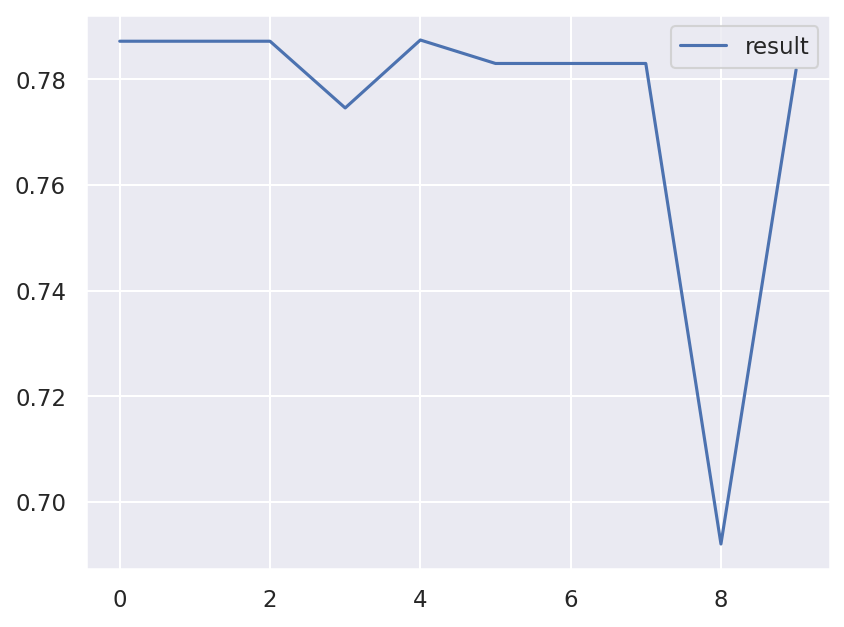

In [57]:
aux = pd.DataFrame(sub_results, columns=["sub","result"])
sns.lineplot(aux)
plt.show()

1: Basic set up
- 80/20 split, random state 2
- All variables except cabin
- Results from LR

2: and 3: Ignore, no changes just uploading, etc.

4: Focused on the few variables that have an ABS(correlation) above 0.2 with Y

5: XGB
- 80/20 split, random state 2
- All variables except cabin
- Results from XGB

6, 7, 8: XGB, playing around with its tuning.

9: "amenities" test, as commented in Kaggle

XGB_2: paid more attention on train/test and focused on having the mean Y of the prediction the closest to mean Y of the train/test dataset
- 0.32 split, random state 1
- All variables except cabin
- Results from XGB